In [ ]:
!pip install qiskit
!pip install qiskit-aer
!pip install qiskit algorithms
!pip install --prefer-binary pyscf
!pip install qiskit_nature
!pip install numpy

In [ ]:
import numpy as np

from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import NLocal, CCXGate, CRZGate, RXGate, XGate


from scipy.optimize import minimize

import matplotlib.pyplot as plt

from qiskit import *
from qiskit.visualization import *
from qiskit_aer import Aer

from qiskit_nature.second_q.hamiltonians import ElectronicEnergy
from qiskit_nature.second_q.problems import ElectronicStructureProblem
from qiskit_nature.second_q.properties import ParticleNumber
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper

ImportError: cannot import name 'BaseSampler' from 'qiskit.primitives' (/usr/local/lib/python3.11/dist-packages/qiskit/primitives/__init__.py)

In [ ]:
# Distancia entre los núcleos
dist = 0.725

# Definimos la geometría molecular
geometry = f"H 0.0 0.0 {-dist/2}; H 0.0 0.0 {dist/2}"

# Configuramos el driver PySCF
driver = PySCFDriver(atom=geometry, basis='sto3g')

# Ejecutamos el driver para obtener el problema de la estructura electrónica
es_problem = driver.run()

# Construimos el Hamiltoniano después de la segunda cuantización
hamiltonian = es_problem.second_q_ops()[0]

# Aplicamos las transformaciones de Jordan-Wigner
mapper = JordanWignerMapper()
hamiltonian = mapper.map(hamiltonian)

print(hamiltonian)

matrix = hamiltonian.to_matrix()

# Diagonalizamos el Hamiltoniano para estudiar directamente sus autovalores
eigenvalues, eigenvectors = np.linalg.eigh(matrix)
print(eigenvalues)

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIZZ', 'IZIZ', 'ZIIZ', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[-0.80718366+0.j,  0.17374013+0.j, -0.23047453+0.j,  0.17374013+0.j,
 -0.23047453+0.j,  0.12148839+0.j,  0.16940471+0.j,  0.1665822 +0.j,
  0.04509381+0.j,  0.04509381+0.j,  0.04509381+0.j,  0.04509381+0.j,
  0.1665822 +0.j,  0.17510657+0.j,  0.12148839+0.j])
[-1.86712098e+00 -1.26243085e+00 -1.26243085e+00 -1.24188257e+00
 -1.24188257e+00 -1.24188257e+00 -1.16036578e+00 -1.16036578e+00
 -8.81132071e-01 -4.65405263e-01 -4.65405263e-01 -3.40532730e-01
 -3.40532730e-01 -2.10506120e-01  4.71844785e-16  2.26937607e-01]


In [ ]:
# Simulador local
simulator = Aer.get_backend('qasm_simulator')

# Ansatz de 4 qubits
theta = Parameter("θ")
ansatz = NLocal(
    num_qubits=4,
    rotation_blocks=[RXGate(theta), CRZGate(theta)],  # Keep rotation blocks
    entanglement_blocks=CCXGate(),
    entanglement=[[0, 1, 2], [1, 2, 3]],  # Define entanglement pattern
    reps=2,
    insert_barriers=True,
)

num_params = ansatz.num_parameters

# Inicialización del parámetro
x0 = 2 * np.pi * np.random.random(num_params)

# Diccionario para almacenar la evolución del costo
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

# Función de coste
def cost_func(params, ansatz, hamiltonian, estimator):
    job = estimator.run([ansatz], [hamiltonian], [params])
    result = job.result()
    energy = result.values[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)

    print(f"Iteración {cost_history_dict['iters']}: Energía = {energy}")

    return energy

# Creamos el estimador para el simulador
backend=simulator
estimator = Estimator()

# Ejecutamos la optimización
res = minimize(
    cost_func,
    x0,
    args=(ansatz, hamiltonian, estimator),
    method="COBYLA",
)

# Resultado final
print("Parámetros óptimos:", res.x)
print("Energía mínima encontrada:", res.fun)

# Graficar evolución del costo
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iteraciones")
ax.set_ylabel("Energía")
plt.show()

NameError: name 'Estimator' is not defined

In [ ]:
nuclear_repulsion = es_problem.nuclear_repulsion_energy # 1/R
print(f"Energía nuclear: {nuclear_repulsion}")
energy = res.fun + nuclear_repulsion
print(f"Energía total: {energy}")

Energía nuclear: 0.7298996012689656
Energía total: -1.1212468446872539


/usr/local/lib/python3.11/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


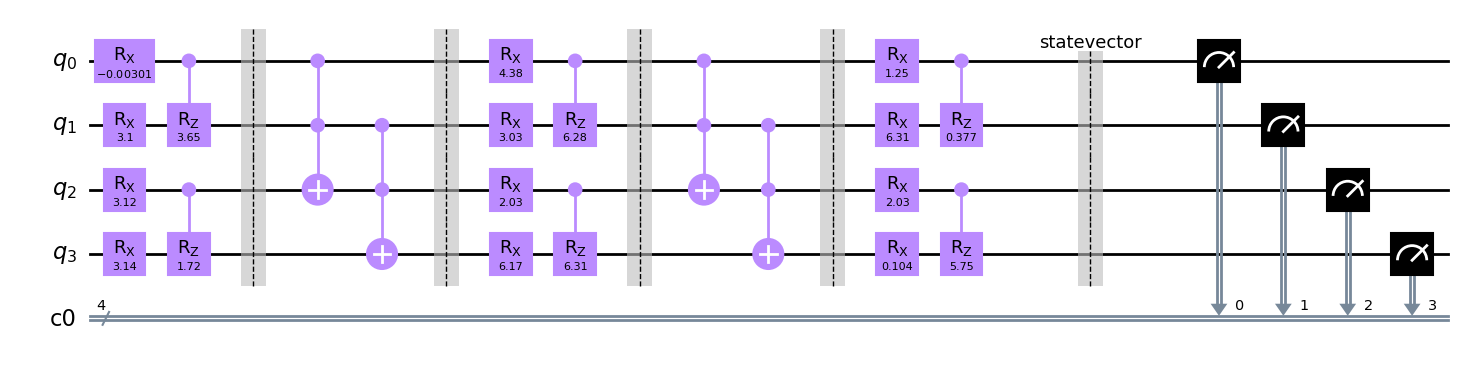

In [ ]:
# Estado cuántico

qc_bound = ansatz.assign_parameters({list(ansatz.parameters)[i]: res.x[i] for i in range(len(res.x))}) # Asignamos los parámetros al circuito

c_reg = ClassicalRegister(ansatz.num_qubits) # Añadimos un bit clásico a qc_bound
qc_bound.add_register(c_reg)

qc_bound.save_statevector() # Guardamos el estado antes de la medida

qc_bound.measure(range(4),range(4)) # Medimos

qc_bound.decompose().draw("mpl") # Dibujamos

Statevector([-2.08262458e-04-6.11946476e-05j,
             -2.70458263e-03+5.32306903e-03j,
              5.69275875e-03-1.48823237e-02j,
              4.90132815e-03+1.94206481e-02j,
              1.54493958e-03+5.04234289e-03j,
             -8.02647621e-01+5.93614991e-01j,
              2.30220023e-02-2.40913412e-03j,
             -1.03933704e-02+2.70760237e-03j,
             -1.49227584e-03+3.70530141e-04j,
             -8.26336207e-03+1.61699799e-03j,
              2.16238947e-02-8.64087304e-03j,
              1.98401257e-02+2.31373366e-02j,
             -2.51962726e-04-2.86976622e-06j,
             -2.46333527e-03-3.35831047e-04j,
              1.50399266e-03-1.57300490e-02j,
              3.53310459e-04-1.44129703e-02j],
            dims=(2, 2, 2, 2))


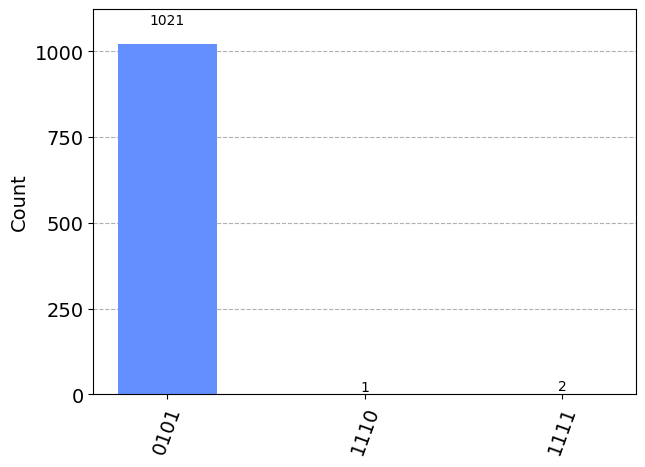

In [ ]:
# Simulamos

sim = Aer.get_backend('qasm_simulator')
my_circuit = transpile(qc_bound, sim)
job = sim.run(my_circuit)
result = job.result()

sv = result.get_statevector()
print(sv)

counts = result.get_counts()
plot_histogram(counts)

Calculando para distancia 0.250 Å
Energía en 0.250 Å: -0.308027 Ha
Calculando para distancia 0.406 Å
Energía en 0.406 Å: -0.916628 Ha
Calculando para distancia 0.562 Å
Energía en 0.562 Å: -1.090277 Ha
Calculando para distancia 0.719 Å
Energía en 0.719 Å: -1.119995 Ha
Calculando para distancia 0.875 Å
Energía en 0.875 Å: -1.097454 Ha
Calculando para distancia 1.031 Å
Energía en 1.031 Å: -1.086235 Ha
Calculando para distancia 1.188 Å
Energía en 1.188 Å: -1.040607 Ha
Calculando para distancia 1.344 Å
Energía en 1.344 Å: -0.967876 Ha
Calculando para distancia 1.500 Å
Energía en 1.500 Å: -0.997878 Ha
Calculando para distancia 1.656 Å
Energía en 1.656 Å: -0.928532 Ha
Calculando para distancia 1.812 Å
Energía en 1.812 Å: -0.917229 Ha
Calculando para distancia 1.969 Å
Energía en 1.969 Å: -0.923587 Ha
Calculando para distancia 2.125 Å
Energía en 2.125 Å: -0.936629 Ha
Calculando para distancia 2.281 Å
Energía en 2.281 Å: -0.932378 Ha
Calculando para distancia 2.438 Å
Energía en 2.438 Å: -0.93132

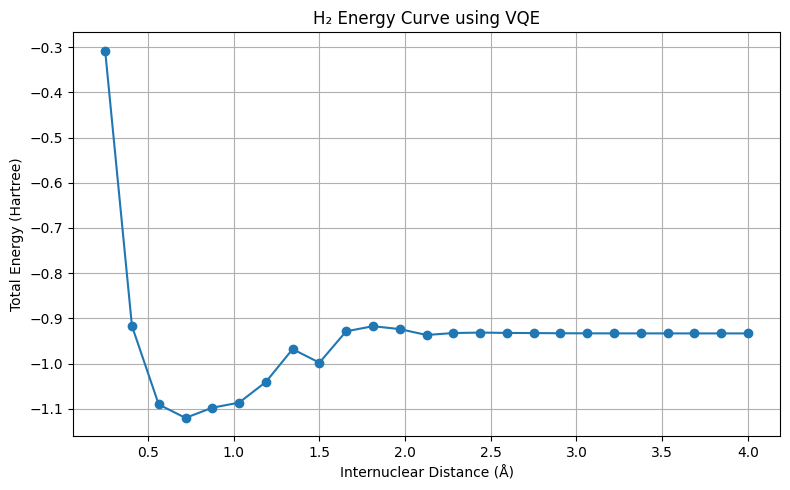

In [ ]:
# Range of distances in Angstroms
distances = np.linspace(0.25, 4, 25)
energies = []

for dist in distances:
    print(f"Calculando para distancia {dist:.3f} Å")

    # Geometry string with correct distance
    geometry = f"H 0.0 0.0 {-dist/2}; H 0.0 0.0 {dist/2}"

    # Set up the driver
    driver = PySCFDriver(atom=geometry, basis='sto3g')
    es_problem = driver.run()

    # Build Hamiltonian
    hamiltonian = es_problem.second_q_ops()[0]
    mapper = JordanWignerMapper()
    hamiltonian = mapper.map(hamiltonian)

    # Define ansatz
    theta = Parameter("θ")
    ansatz = NLocal(
        num_qubits=4,
        rotation_blocks=[RXGate(theta), CRZGate(theta)],
        entanglement_blocks=CCXGate(),
        entanglement=[[0, 1, 2], [1, 2, 3]],
        reps=2,
        insert_barriers=True,
    )
    for qubit in [0, 2]:
        ansatz.add_layer(XGate(), [qubit])

    num_params = ansatz.num_parameters
    x0 = 2 * np.pi * np.random.random(num_params)

    # Reset cost tracking
    cost_history_dict = {"prev_vector": None, "iters": 0, "cost_history": []}

    # Cost function
    def cost_func(params, ansatz, hamiltonian, estimator):
        job = estimator.run([ansatz], [hamiltonian], [params])
        result = job.result()
        energy = result.values[0]
        cost_history_dict["iters"] += 1
        cost_history_dict["prev_vector"] = params
        cost_history_dict["cost_history"].append(energy)
        return energy

    # Estimator
    estimator = Estimator()

    # Optimize
    res = minimize(
        cost_func,
        x0,
        args=(ansatz, hamiltonian, estimator),
        method="COBYLA",
    )

    # Total energy (electronic + nuclear repulsion)
    nuclear_repulsion = es_problem.nuclear_repulsion_energy
    total_energy = res.fun + nuclear_repulsion
    energies.append(total_energy)

    print(f"Energía en {dist:.3f} Å: {total_energy:.6f} Ha")

# Plot the potential energy curve
plt.figure(figsize=(8, 5))
plt.plot(distances, energies, marker='o', linestyle='-')
plt.title("H₂ Energy Curve using VQE")
plt.xlabel("Internuclear Distance (Å)")
plt.ylabel("Total Energy (Hartree)")
plt.grid(True)
plt.tight_layout()
plt.show()
